Training model for N-back = 0


Training N=0: 100%|██████████| 50/50 [00:50<00:00,  1.00s/it]


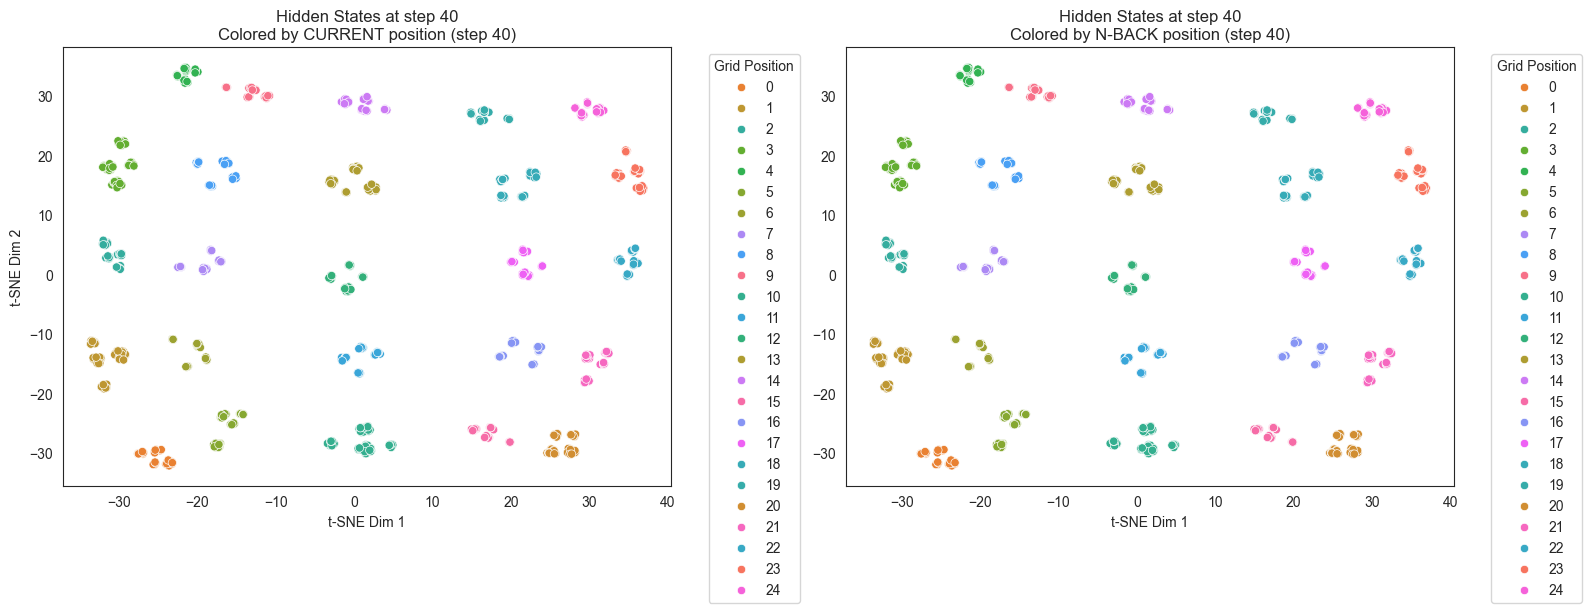

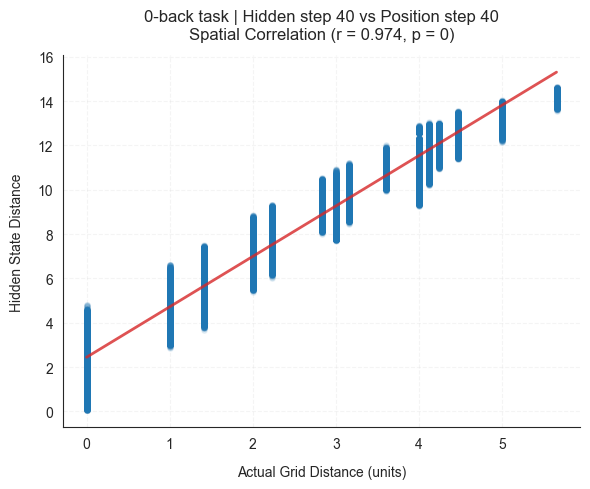

Training model for N-back = 1


Training N=1: 100%|██████████| 50/50 [00:50<00:00,  1.02s/it]


Training model for N-back = 2


Training N=2: 100%|██████████| 50/50 [00:51<00:00,  1.02s/it]


Training model for N-back = 3


Training N=3: 100%|██████████| 50/50 [00:53<00:00,  1.07s/it]


Training model for N-back = 4


Training N=4: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


Training model for N-back = 5


Training N=5: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it]


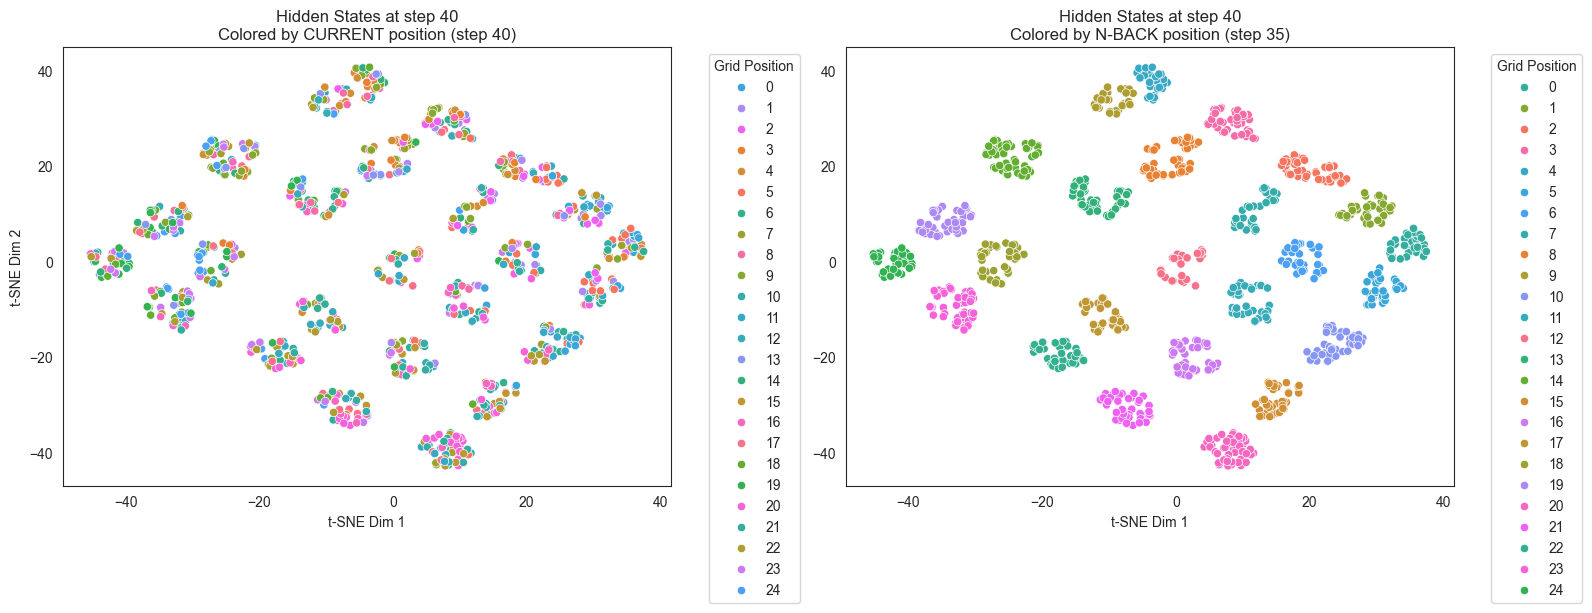

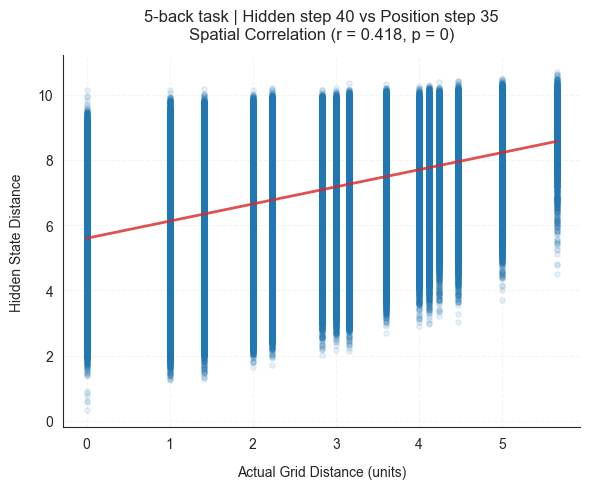

Training model for N-back = 6


Training N=6: 100%|██████████| 50/50 [00:52<00:00,  1.06s/it]


Training model for N-back = 7


Training N=7: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it]


Training model for N-back = 8


Training N=8: 100%|██████████| 50/50 [00:56<00:00,  1.14s/it]


Training model for N-back = 9


Training N=9: 100%|██████████| 50/50 [00:57<00:00,  1.15s/it]


Training model for N-back = 10


Training N=10: 100%|██████████| 50/50 [00:57<00:00,  1.14s/it]


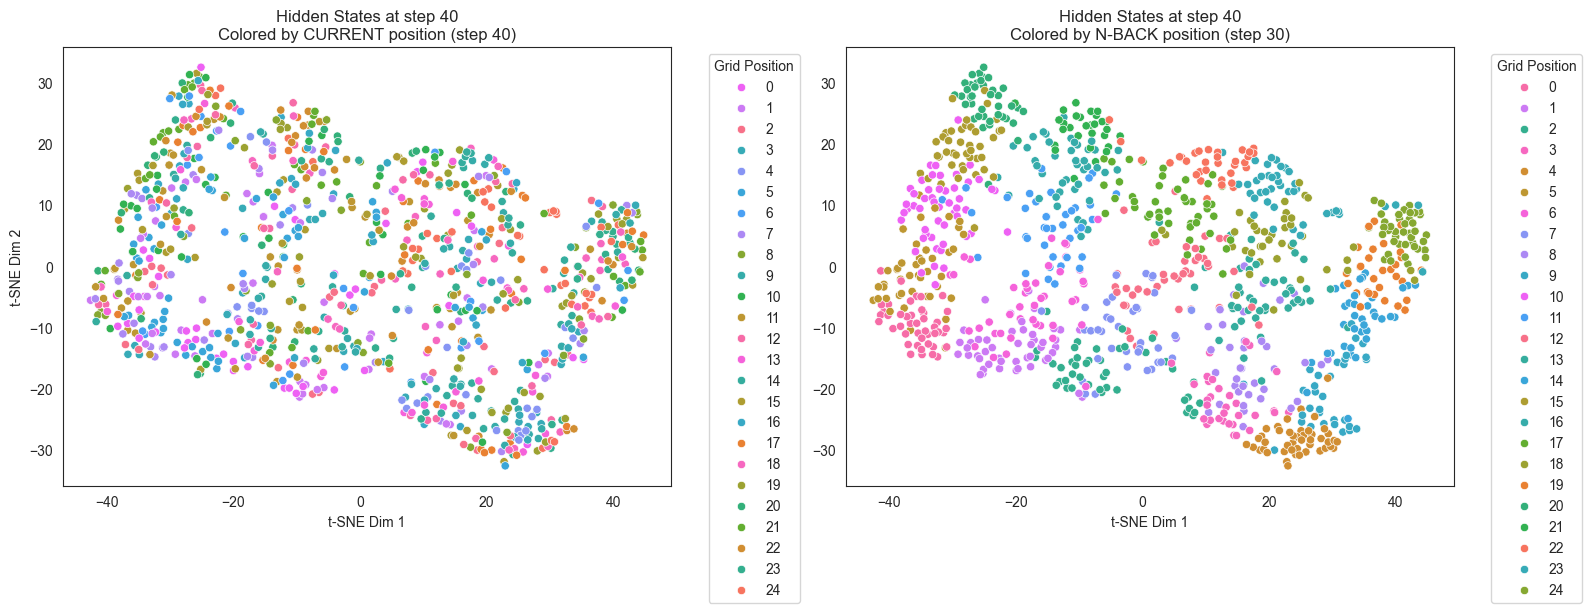

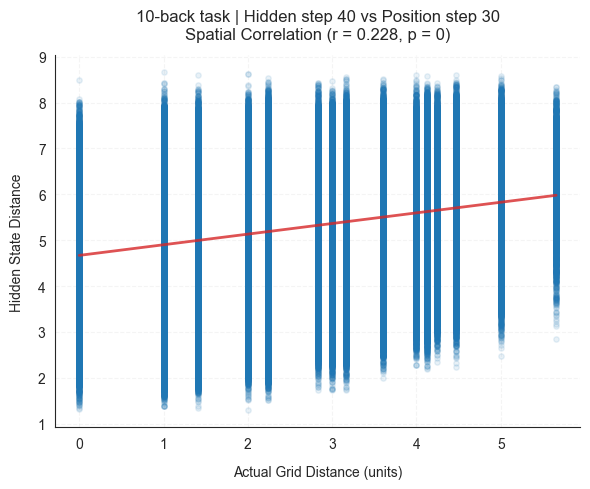

Training model for N-back = 11


Training N=11: 100%|██████████| 50/50 [00:57<00:00,  1.15s/it]


Training model for N-back = 12


Training N=12: 100%|██████████| 50/50 [00:57<00:00,  1.14s/it]


Training model for N-back = 13


Training N=13: 100%|██████████| 50/50 [00:57<00:00,  1.14s/it]


Training model for N-back = 14


Training N=14: 100%|██████████| 50/50 [00:52<00:00,  1.04s/it]


Training model for N-back = 15


Training N=15: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]


Training model for N-back = 16


Training N=16: 100%|██████████| 50/50 [00:40<00:00,  1.23it/s]


Training model for N-back = 17


Training N=17: 100%|██████████| 50/50 [00:40<00:00,  1.24it/s]


Training model for N-back = 18


Training N=18: 100%|██████████| 50/50 [00:43<00:00,  1.16it/s]


Training model for N-back = 19


Training N=19: 100%|██████████| 50/50 [00:56<00:00,  1.14s/it]


Training model for N-back = 20


Training N=20: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]


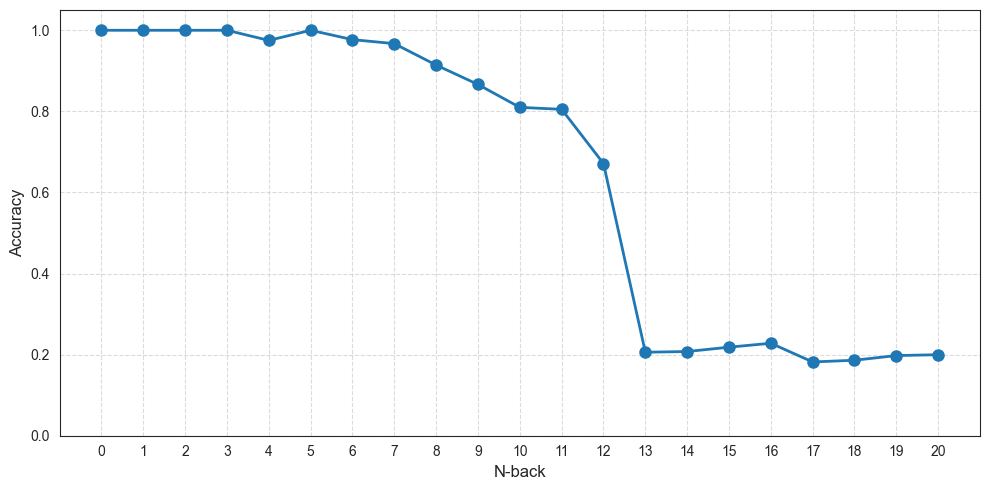

In [2]:
from lstm_explorer import sample_and_train, get_hidden_states, NBackDataset
from lstm_plots import plot_tsne, plot_spatial_correlation, plot_accuracies

accuracies = []
n_max=20
for n_back in range(n_max + 1):
    print(f"Training model for N-back = {n_back}")
    model, accuracy, test_loss, train_loss = sample_and_train(n_back)
    accuracies.append(accuracy)

    if n_back in [0, 5, 10]: # Only plot for N = 0, 5, 10
        # Get hidden states for t-SNE and correlation
        test_dataset = NBackDataset(10_000, n_back) 
        hidden_states, current_labels, nback_labels = get_hidden_states(
            model, test_dataset, time_step=40, n_back=n_back
        )

        # t-SNE visualization
        plot_tsne(hidden_states, current_labels, nback_labels, n_back)

        # Spatial correlation
        plot_spatial_correlation(
            hidden_states=hidden_states,
            grid_positions=current_labels,
            hidden_step=40,
            N=n_back
        )

# Plot accuracy curve across all N
plot_accuracies(accuracies)